In [59]:
import os
import numpy as np
import pandas as pd
import warnings

from PIL import Image
from skimage.color import rgb2gray
import xml.etree.ElementTree as ET
from skimage import io, exposure, filters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold


import matplotlib.pyplot as plt

In [60]:
warnings.filterwarnings("ignore")

In [61]:
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [62]:
new_dir = "./updated"

In [63]:
class_paths = os.listdir(new_dir)

In [64]:
class_paths

['n02110063-malamute',
 'n02093859-Kerry_blue_terrier',
 'n02100236-German_short-haired_pointer',
 'n02102177-Welsh_springer_spaniel']

In [65]:
class_names = [i[10:] for i in class_paths]

In [66]:
class_names

['malamute',
 'Kerry_blue_terrier',
 'German_short-haired_pointer',
 'Welsh_springer_spaniel']

# 2

In [67]:
df = pd.DataFrame(columns = list(range(0,36))+['class'])
for class_ in class_paths:
  class_path = os.path.join(new_dir,class_)
  for filename in os.listdir(class_path):
    img = io.imread(os.path.join(class_path,filename))
    gray_sacle = rgb2gray(img)
    angle_sobel = angle(filters.sobel_h(gray_sacle),
                    filters.sobel_v(gray_sacle))
    hist,bins = exposure.histogram(angle_sobel,nbins=36)


    for i in class_names:
      if i.lower() in class_.lower():
        break
    df.loc[len(df)] = list(hist)+[class_names.index(i)]




In [68]:
df.to_csv("hist_datset.csv")

In [69]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,class
0,844,718,573,493,487,450,401,393,387,353,...,436,476,436,492,503,595,638,683,716,0
1,601,404,331,330,334,359,371,374,349,380,...,461,462,413,408,384,439,441,452,519,0
2,549,503,505,485,473,509,481,545,504,488,...,378,396,411,445,456,439,468,457,510,0
3,460,458,439,482,408,486,451,463,454,459,...,453,401,412,433,401,469,431,394,456,0
4,506,457,419,451,466,486,481,456,458,478,...,428,408,422,405,425,466,437,463,417,0


## 3

In [70]:
X = np.array(df[df.columns[:-1]])
y = np.array(df['class'])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## 4,5

In [72]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [73]:
scalled_x_train= scaler.transform(X_train)
scalled_x_test = scaler.transform(X_test)

## 6

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
classifiers = [DecisionTreeClassifier(max_depth=10),GaussianNB(), AdaBoostClassifier()]
classifier_names = ['Decision Tree', 'Naive Bayes','Ada Boost']

In [76]:
val_accs = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for classifier in classifiers:
  temp = []
  for fold, (start_train_index, val_index) in enumerate(skf.split(scalled_x_train, y_train)):
    X_start_train, X_val = scalled_x_train[start_train_index], scalled_x_train[val_index]
    y_start_train, y_val = y_train[start_train_index], y_train[val_index]
    classifier.fit(X_start_train, y_start_train)
    y_pred = classifier.predict(X_val)
    temp.append(accuracy_score(y_val,y_pred))
  val_accs.append(np.mean(temp))


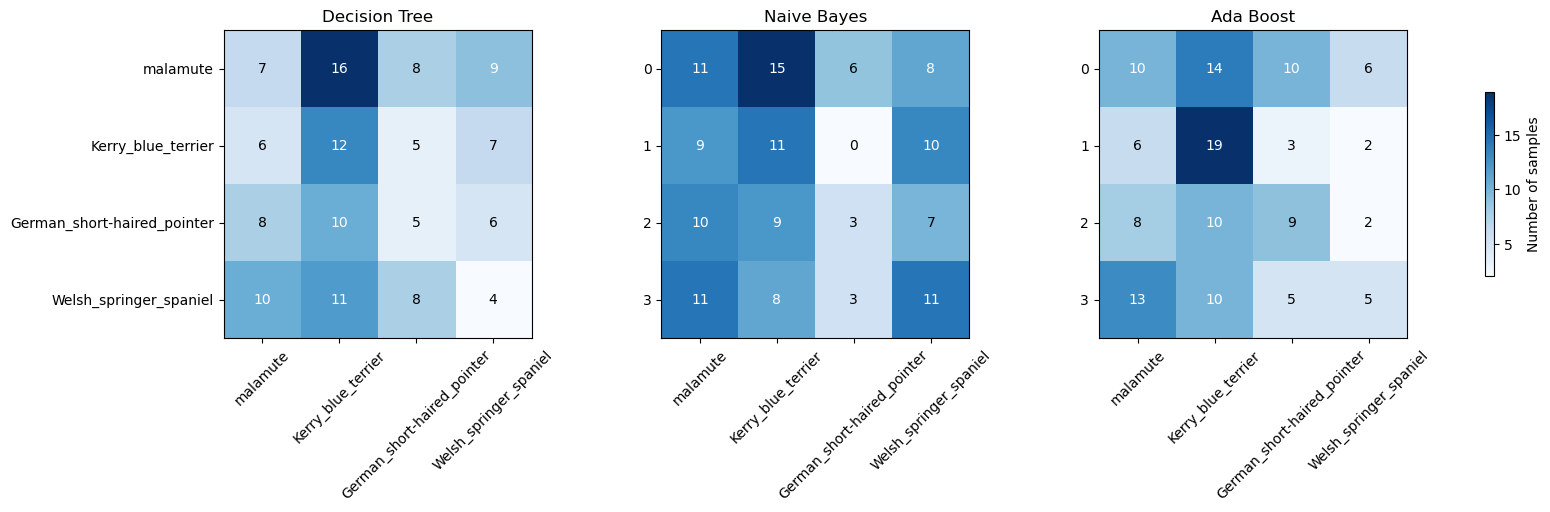

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))
ind = 0
for name, classifier in zip(classifier_names,classifiers):
  y_pred = classifier.predict(scalled_x_test)
  cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

  im = axes[ind].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


  axes[ind].set_xticks(np.arange(len(class_names)))
  axes[ind].set_yticks(np.arange(len(class_names)))
  axes[ind].set_xticklabels(class_names,rotation=45)
  if ind==0:
    axes[ind].set_yticklabels(class_names)
  axes[ind].set_title(name)

  for i in range(len(class_names)):
      for j in range(len(class_names)):
          axes[ind].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
  ind+=1

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.set_ylabel('Number of samples')

plt.show()

#used this website for just guidence : https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

## Part: 6a

## Ada Boost is looking best becasue on the confusion Matrix we can see that there is more darker color on diagonal 
## Naive Bayes also have good number of darker diagonal elements so that this two are better method.

## Part: 6b

In [80]:
for clf_name, acc in zip(classifier_names,val_accs):
  print(f"{clf_name} Mean Val accuracy accross K folds {np.mean(acc)}")

Decision Tree Mean Val accuracy accross K folds 0.28283917340521114
Naive Bayes Mean Val accuracy accross K folds 0.35496855345911954
Ada Boost Mean Val accuracy accross K folds 0.29044025157232706


## The best method, based on the mean validation accuracy, is Naive Bayes.
## It has the highest accuracy (0.3549) 35.49%

## Part: 6c and 6d

In [81]:
from sklearn.metrics import f1_score

In [82]:
test_acc = []
f_scores = []
for clf_name, clf in zip(classifier_names,classifiers):
  clf.fit(scalled_x_train,y_train)
  y_pred = clf.predict(scalled_x_test)
  test_acc.append(accuracy_score(y_test,y_pred))
  f_scores.append(f1_score(y_test, y_pred, average='micro'))


In [92]:
for clf_name, acc, f1 in zip(classifier_names,test_acc,f_scores):
  print(f"{clf_name} has Test accuracy  {acc:.3f} and F1 score {f1:.3f}")


Decision Tree has Test accuracy  0.311 and F1 score 0.311
Naive Bayes has Test accuracy  0.265 and F1 score 0.265
Ada Boost has Test accuracy  0.288 and F1 score 0.288


## Decision Tree is best in both Test accuracy and F1 score

# Part : 7

In [103]:
mean_val_errors_std = []
mean_val_errors_strat = []
mean_train_errors_std = []
mean_train_errors_strat = []
k_values = [0.1,1,10,100]
for k in k_values:
    # Standard 5-fold cross-validation
    kf = KFold(n_splits=5,shuffle=True,random_state=10)
    model1 = LinearSVC(C=k)
    val_scores_std = cross_val_score(model1, scalled_x_train, y_train, cv=kf)
    train_scores_std = model1.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    mean_val_errors_std.append(1 - np.mean(val_scores_std))
    mean_train_errors_std.append(1 - train_scores_std)

    model2 = LinearSVC(C=k)
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
    val_scores_strat = cross_val_score(model2, scalled_x_train, y_train, cv=skf)
    train_scores_strat = model2.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    mean_val_errors_strat.append(1 - np.mean(val_scores_strat))
    mean_train_errors_strat.append(1 - train_scores_strat)


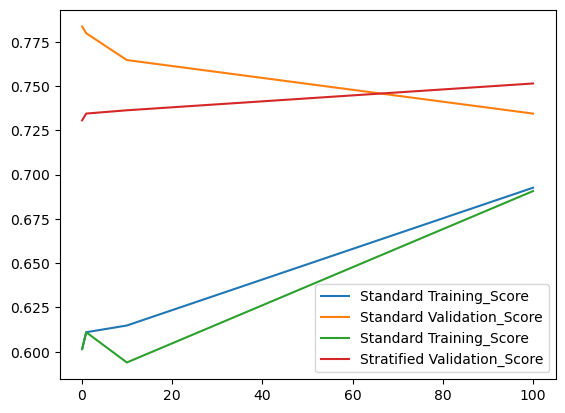

In [110]:
fig,ax = plt.subplots()
ax.plot(k_values,mean_train_errors_std,label="Standard Training_Score")
ax.plot(k_values,mean_val_errors_std,label="Standard Validation_Score")
ax.plot(k_values,mean_train_errors_strat,label="Standard Training_Score")
ax.plot(k_values,mean_val_errors_strat,label="Stratified Validation_Score")
ax.legend()
plt.show()

In [105]:
print(f"Lowest Standrad Training mean Error is {np.min(mean_train_errors_std)} at  C =  {k_values[np.argmin(mean_train_errors_std)]}")
print(f"Lowest Standrad validation mean Error is {np.min(mean_val_errors_std)}  at  C = {k_values[np.argmin(mean_val_errors_std)]}")
print(f"Lowest Stratified Training mean Error is {np.min(mean_train_errors_strat)} at C = {k_values[np.argmin(mean_train_errors_strat)]}")
print(f"Lowest Stratified validation mean Error is {np.min(mean_val_errors_strat)} at C = {k_values[np.argmin(mean_val_errors_strat)]}")

Lowest Standrad Training mean Error is 0.6015180265654649 at  C =  0.1
Lowest Standrad validation mean Error is 0.7344474393530998  at  C = 100
Lowest Stratified Training mean Error is 0.5939278937381405 at C = 10
Lowest Stratified validation mean Error is 0.7306558849955077 at C = 0.1


## Small C allows for large margin whihc lead to underfitting if the model is too simple.
## Large C which might lead to a more complex model and resulting in overfitting.

In [106]:
knn = LinearSVC(C=100)
knn.fit(scalled_x_train,y_train)
error = 1- knn.score(scalled_x_test,y_test)

In [107]:
error

0.7121212121212122

## Error for the test dataset : 0.712